In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import os
import glob
import shutil

In [0]:
_URL = 'ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="cell_images.zip",
                                   extract=True)

In [0]:
base_dir = os.path.join(os.path.dirname(zip_file), 'cell_images')

In [14]:
zip_dir_base = os.path.dirname(base_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cell_images
/root/.keras/datasets/cell_images/Uninfected
/root/.keras/datasets/cell_images/Parasitized


In [0]:
classes = ['Uninfected', 'Parasitized']

In [26]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Uninfected: 13779 Images
Parasitized: 13779 Images


In [27]:
zip_dir_base = os.path.dirname(base_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cell_images
/root/.keras/datasets/cell_images/Uninfected
/root/.keras/datasets/cell_images/Parasitized
/root/.keras/datasets/cell_images/train
/root/.keras/datasets/cell_images/train/Uninfected
/root/.keras/datasets/cell_images/train/Parasitized
/root/.keras/datasets/cell_images/val
/root/.keras/datasets/cell_images/val/Uninfected
/root/.keras/datasets/cell_images/val/Parasitized


In [28]:
round(len(images)*0.8)

11023

In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [0]:
batch_size = 100
IMG_SHAPE = 150 

In [31]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 22046 images belonging to 2 classes.


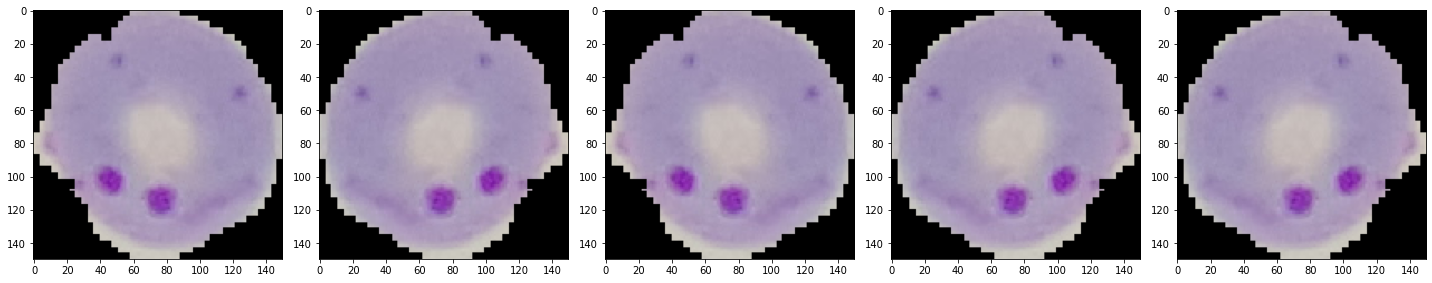

In [32]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [33]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='binary'
                                                )

Found 22046 images belonging to 2 classes.


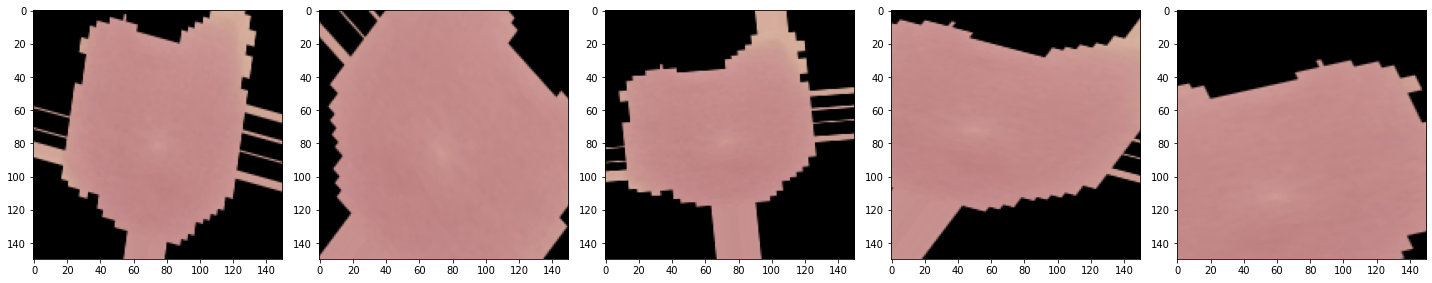

In [34]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [35]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 5512 images belonging to 2 classes.


In [0]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs = 10

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/10
221/221 [==============================] - 587s 3s/step - loss: 0.4757 - accuracy: 0.7995 - val_loss: 0.3937 - val_accuracy: 0.8625
Epoch 2/10
221/221 [==============================] - 594s 3s/step - loss: 0.3496 - accuracy: 0.8812 - val_loss: 0.1941 - val_accuracy: 0.9528
Epoch 3/10
221/221 [==============================] - 599s 3s/step - loss: 0.2755 - accuracy: 0.9031 - val_loss: 0.1711 - val_accuracy: 0.9412
Epoch 4/10
221/221 [==============================] - 597s 3s/step - loss: 0.2574 - accuracy: 0.9071 - val_loss: 0.1575 - val_accuracy: 0.9512
Epoch 5/10
221/221 [==============================] - 596s 3s/step - loss: 0.2395 - accuracy: 0.9146 - val_loss: 0.1717 - val_accuracy: 0.9459
Epoch 6/10
221/221 [==============================] - 584s 3s/step - loss: 0.2334 - accuracy: 0.9182 - val_loss: 0.1594 - val_accuracy: 0.9492
Epoch 7/10
221/221 [==============================] - 586s 3s/step - loss: 0.2279 - accuracy: 0.9201 - val_loss: 0.1386 - val_accuracy: 0.9548